<a href="https://colab.research.google.com/github/no197/ML_Youtube_Spam_Detection/blob/master/Youtube_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

**download & extract dataset**

In [1]:
!wget -O data.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
!unzip data.zip

--2020-05-28 02:15:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163567 (160K) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>] 159.73K   292KB/s    in 0.5s    

2020-05-28 02:15:49 (292 KB/s) - ‘data.zip’ saved [163567/163567]

Archive:  data.zip
  inflating: Youtube01-Psy.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._Youtube01-Psy.csv  
  inflating: Youtube02-KatyPerry.csv  
  inflating: __MACOSX/._Youtube02-KatyPerry.csv  
  inflating: Youtube03-LMFAO.csv     
  inflating: __MACOSX/._Youtube03-LMFAO.csv  
  inflating: Youtube04-Eminem.csv    
  inflating: __MACOSX/._Youtube04-Eminem.csv  
  inflating: Youtube05-Shakira.csv   
  inflating: __MACOSX/._Youtube05-

**import lib**

In [2]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
# from sklearn.externals import joblib
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Import data into Pandas**

In [3]:
path = '/content' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    data_frame = pd.read_csv(filename, index_col=None, header=0, encoding='utf-8')
    li.append(data_frame)

df = pd.concat(li, axis=0, ignore_index=True)
print(df.shape)
df.head(5)


(1956, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


**DATA VISUALIZATION**

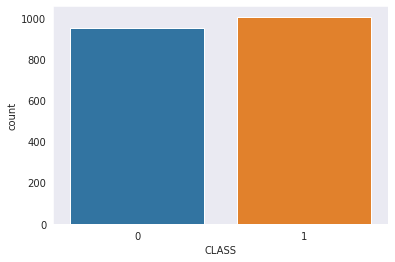

In [4]:
sns.set_style("dark")
sns.countplot(df.CLASS)

**See how our content look like**

In [5]:
for i,content in enumerate (df['CONTENT'], 1):
    if i > 20:
        break
    else:
        print(i, content)



1 Huh, anyway check out this you[tube] channel: kobyoshi02
2 Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!
3 just for test I have to say murdev.com
4 me shaking my sexy ass on my channel enjoy ^_^ ﻿
5 watch?v=vtaRGgvGtWQ   Check this out .﻿
6 Hey, check out my new website!! This site is about kids stuff. kidsmediausa  . com
7 Subscribe to my channel ﻿
8 i turned it on mute as soon is i came on i just wanted to check the  views...﻿
9 You should check my channel for Funny VIDEOS!!﻿
10 and u should.d check my channel and tell me what I should do next!﻿
11 Hey subscribe to me﻿
12  Once you have started reading do not stop. If you do not subscribe to me  within one day you and you're entire family will die so if you want to stay  alive subscribe right now.﻿
13 https://twitter.com/GBphotographyGB﻿
14 subscribe like comment﻿
15 please like :D https://premium.easypromosapp.c

**Text cleansing, remove digits, remove punctuation, remove html tags**

In [11]:
hl_cleansed = []
cleanr = re.compile('<.*?>')
for hl in df['CONTENT']:
    hl=re.sub(cleanr, ' ', hl)
    #     Remove punctuations
    clean = hl.translate(str.maketrans('', '', punctuation))
    #clean = clean.translate(str.maketrans('', '', punctuation))
    #     Remove digits/numbers
    clean = clean.translate(str.maketrans('', '', digits))
    hl_cleansed.append(clean)
    
# View comparison
index=2
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter cleansed :')
print(hl_cleansed[index])

Original texts :
just for test I have to say murdev.com

After cleansed :
just for test I have to say murdevcom


**Tokenization**

In [12]:
# Tokenization process
hl_tokens = []
for hl in hl_cleansed:
    hl_tokens.append(hl.split())

# View Comparison
index=2
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
just for test I have to say murdevcom

After tokenization :
['just', 'for', 'test', 'I', 'have', 'to', 'say', 'murdevcom']


**Lemmatization**

In [13]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

hl_lemmatized = []
for tokens in hl_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    hl_lemmatized.append(lemm)
    
# Example comparison
word_1 = ['skyrim','dragons', 'are', 'having', 'parties']
word_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]
print('Before lemmatization :\t',word_1)
print('After lemmatization :\t',word_2)

Before lemmatization :	 ['skyrim', 'dragons', 'are', 'having', 'parties']
After lemmatization :	 ['skyrim', 'dragon', 'be', 'have', 'party']


# ***Training LSTM Model***

In [0]:
# Vectorize and convert text into sequences
max_features = 2000
max_token = len(max(hl_lemmatized))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_lemmatized)
sequences = tokenizer.texts_to_sequences(hl_lemmatized)
X = pad_sequences(sequences, maxlen=max_token)

Split Train, Test

In [0]:
Y = df['CLASS'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

Building the Model

In [0]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Training process

In [17]:
epoch = 20
batch_size = 128
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1095 samples, validate on 274 samples
Epoch 1/20
 - 2s - loss: 0.6892 - accuracy: 0.5991 - val_loss: 0.6839 - val_accuracy: 0.6934
Epoch 2/20
 - 0s - loss: 0.6727 - accuracy: 0.7187 - val_loss: 0.6524 - val_accuracy: 0.7190
Epoch 3/20
 - 0s - loss: 0.6126 - accuracy: 0.7452 - val_loss: 0.5457 - val_accuracy: 0.7226
Epoch 4/20
 - 0s - loss: 0.4987 - accuracy: 0.7589 - val_loss: 0.4470 - val_accuracy: 0.7774
Epoch 5/20
 - 0s - loss: 0.3875 - accuracy: 0.8530 - val_loss: 0.3859 - val_accuracy: 0.8358
Epoch 6/20
 - 0s - loss: 0.3021 - accuracy: 0.8831 - val_loss: 0.3168 - val_accuracy: 0.8723
Epoch 7/20
 - 0s - loss: 0.2288 - accuracy: 0.9096 - val_loss: 0.2898 - val_accuracy: 0.9161
Epoch 8/20
 - 0s - loss: 0.1948 - accuracy: 0.9251 - val_loss: 0.3720 - val_accuracy: 0.9124
Epoch 9/20
 - 0s - loss: 0.1704 - accuracy: 0.9315 - val_loss: 0.5609 - val_accuracy: 0.9161
Epoch 10/20
 - 0s - loss: 0.1419 - accuracy: 0.9397 - val_loss: 0.9427 - val_accuracy: 0.9234
Epoch 11/20
 - 0s - lo

# ***Model Evaluation***



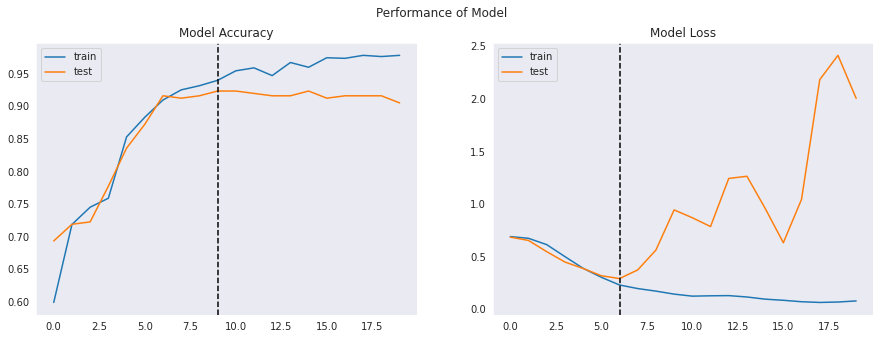

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# ***Test Model***

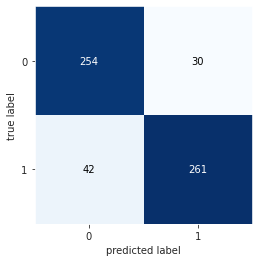

In [19]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [20]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       284
           1       0.90      0.86      0.88       303

    accuracy                           0.88       587
   macro avg       0.88      0.88      0.88       587
weighted avg       0.88      0.88      0.88       587



# ***Use Another ML Algorithms to Classify***

**Preparing the Data**

In [0]:
X = [" ".join(x) for x in hl_lemmatized]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['CLASS'],test_size=0.3)

**Word Vectorization using TF-IDF**

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [25]:
print(Tfidf_vect.vocabulary_)

{'huh': 1600, 'anyway': 156, 'check': 488, 'out': 2352, 'this': 3230, 'youtube': 3665, 'channel': 472, 'kobyoshi': 1828, 'hey': 1375, 'guy': 1301, 'my': 2202, 'new': 2233, 'and': 131, 'our': 2350, 'first': 1090, 'vid': 3414, 'is': 1717, 'us': 3382, 'the': 3206, 'monkeys': 2151, 'im': 1642, 'monkey': 2150, 'in': 1656, 'white': 3544, 'shirtplease': 2860, 'leave': 1876, 'like': 1900, 'comment': 566, 'please': 2462, 'subscribe': 3082, 'just': 1781, 'for': 1117, 'test': 3188, 'have': 1344, 'to': 3260, 'say': 2783, 'murdevcom': 2188, 'me': 2051, 'shake': 2840, 'sexy': 2837, 'as': 186, 'on': 2321, 'enjoy': 922, 'watchvvtarggvgtwq': 3498, 'website': 3514, 'site': 2908, 'be': 260, 'about': 7, 'kid': 1807, 'stuff': 3071, 'kidsmediausa': 1809, 'com': 557, 'turn': 3326, 'it': 1721, 'mute': 2199, 'soon': 2977, 'come': 558, 'want': 3471, 'views': 3428, 'you': 3652, 'should': 2873, 'funny': 1174, 'videos': 3418, 'shouldd': 2874, 'tell': 3180, 'what': 3532, 'do': 801, 'next': 2235, 'once': 2322, 'star

## **Trainning on the SVM classifier**

In [26]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

**Predict and evaluate the SVM classifier**

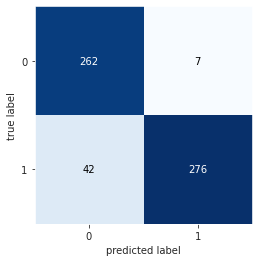

In [27]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [28]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       269
           1       0.98      0.87      0.92       318

    accuracy                           0.92       587
   macro avg       0.92      0.92      0.92       587
weighted avg       0.92      0.92      0.92       587



## **Trainning on the Naive Bayes Classifier**

In [29]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Predict and evaluate the Naive Bayes Classifier**

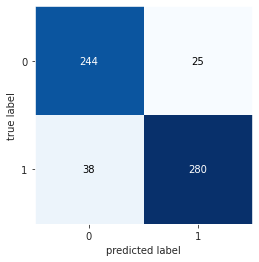

In [30]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [31]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       269
           1       0.92      0.88      0.90       318

    accuracy                           0.89       587
   macro avg       0.89      0.89      0.89       587
weighted avg       0.89      0.89      0.89       587



# ***Save model***

In [32]:
joblib.dump(Tfidf_vect, '/content/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/model/SVM_model.pkl')
joblib.dump(Naive, '/content/model/NB_model.pkl')

['/content/model/NB_model.pkl']

# ***Enter comment and check***

## *utils*

In [0]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
import string
from string import digits, punctuation

def word_lenmatizer(text):
    cleanr = re.compile('<.*?>')
    text=re.sub(cleanr, ' ', text)
    clean = text.translate(str.maketrans('', '', punctuation))
    clean = clean.translate(str.maketrans('', '', digits))
    text_tokenizer=clean.split()
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    hl_lemmatized = []
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_tokenizer]
    hl_lemmatized.append(lemm)
    return hl_lemmatized

def LSTM_predict(text,model,tokenizer):
  w_lenmatizer=word_lenmatizer(text)
  max_token = 14
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=max_token)
  if np.around(model.predict(X)[0])==1:
    print(text)
    print("=============> SPAM\n")
  else:
    print(text)
    print("=============> HAM\n")

def predict(text,model,tfidf_vector):
  w_lenmatizer=word_lenmatizer(text)
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  X_Tfidf = tfidf_vector.transform(w_lenmatizer)
  if model.predict(X_Tfidf)[0]==1:
    print(text)
    print("=============> SPAM\n")
  else:
    print(text)
    print("=============> HAM\n")



## Predict

Load model 

In [33]:
model_LSTM=joblib.load('/content/model/LSTM_model.pkl')
tokenizer_LSTM=joblib.load('/content/model/tokenizer_LSTM.pkl')
SVM_model=joblib.load('/content/model/SVM_model.pkl')
NB_model=joblib.load('/content/model/NB_model.pkl')
tfidf_vec=joblib.load('/content/model/tfidf.pkl')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using LSTM model to predict

In [36]:
cmt='Please subcribe my channel'
LSTM_predict(cmt,model_LSTM,tokenizer_LSTM)

cmt1="Hand Up 🤘🏽"
LSTM_predict(cmt1,model_LSTM,tokenizer_LSTM)


cmt2='I just remembered the song because of Alvin and The Chipmunks 😂'
LSTM_predict(cmt2,model_LSTM,tokenizer_LSTM)

cmt3="Click me! to see beautiful girl"
LSTM_predict(cmt3,model_LSTM,tokenizer_LSTM)

cmt4="Please give me a like on Facebook"
LSTM_predict(cmt4,model_LSTM,tokenizer_LSTM)

Please subcribe my channel
=============> SPAM

Hand Up 🤘🏽
=============> SPAM

I just remembered the song because of Alvin and The Chipmunks 😂
=============> HAM

Click me! to see beautiful girl
=============> SPAM

Please give me a like on Facebook
=============> SPAM



Using SVM clasifier

In [0]:
cmt='Follow me on instagram, remember to like and subcribe'
predict(cmt,SVM_model,tfidf_vec)

cmt1='D O Y O U G U Y S R E M E M B E R T H E  T I M E W H E N Big PP used to be "very nice"?'
predict(cmt,SVM_model,tfidf_vec)

cmt2='This is probably the best song that represents the world cup ever.'
predict(cmt2,SVM_model,tfidf_vec)

cmt3='You want to earn more money? Click here 👉: bit.ly/earn_money.com'
predict(cmt3,SVM_model,tfidf_vec)

Using NB clasifier


In [0]:
cmt='Such a shame that this song didnt reach 1B in 10 years.'
predict(cmt,NB_model,tfidf_vec)

cmt1="Like for me <3"
predict(cmt1,NB_model,tfidf_vec)

cmt2='LIKE THIS COMMENT IF YOU ARE WATCHING.'
predict(cmt2,NB_model,tfidf_vec)